# DTSA 5510 Unsupervised Algorithms in Machine Learning Final Project

## 1: Gather data, determine the method of data collection and provenance of the data
### Wine Recognition Dataset
The dataset contains the results of a chemical analysis of wines grown in the same region in Italy, but derived from three different cultivars (which serves as the "true" but unseen label in this unsupervised analysis). dataset found here: https://archive.ics.uci.edu/dataset/109/wine

In [25]:
import pandas as pd
from pyarrow.pandas_compat import dataframe_to_types
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine = fetch_ucirepo(id=109)

# data (as pandas dataframes)
X = wine.data.features
y = wine.data.targets

df = pd.concat([y, X], axis=1)

# variable information
print(wine.variables)


   class  Alcohol  Malicacid   Ash  Alcalinity_of_ash  Magnesium  \
0      1    14.23       1.71  2.43               15.6        127   
1      1    13.20       1.78  2.14               11.2        100   
2      1    13.16       2.36  2.67               18.6        101   
3      1    14.37       1.95  2.50               16.8        113   
4      1    13.24       2.59  2.87               21.0        118   

   Total_phenols  Flavanoids  Nonflavanoid_phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color_intensity   Hue  0D280_0D315_of_diluted_wines  Proline  
0             5.64  1.04                          3.92     1065  
1             4.38  1.05        

Dataset Features: Contains 178 instances with 13 continuous numerical features describing the chemical analysis of wines grown in the same region in Italy but derived from three different cultivators.  Features include Alcohol, Malic Acid, Ash, Alkalinity of Ash, Magnesium, Phenols, Flavanoids, etc...

## 2: Identify an Unsupervised Learning Problem
Unsupervised Goal: Group the wines into clusters that align with the three types of cultivators.

## 3: Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data


In [26]:
print(df.head())
print(df.info())
print(df.describe())

   class  Alcohol  Malicacid   Ash  Alcalinity_of_ash  Magnesium  \
0      1    14.23       1.71  2.43               15.6        127   
1      1    13.20       1.78  2.14               11.2        100   
2      1    13.16       2.36  2.67               18.6        101   
3      1    14.37       1.95  2.50               16.8        113   
4      1    13.24       2.59  2.87               21.0        118   

   Total_phenols  Flavanoids  Nonflavanoid_phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color_intensity   Hue  0D280_0D315_of_diluted_wines  Proline  
0             5.64  1.04                          3.92     1065  
1             4.38  1.05        

Observation: It appears that features have vastly different scales.  We will address this using a scaler to ensure that distance-based classifiers like KNN are not dominated by high magnitude features.

In [ ]:
# Libraries
import seaborn as sns
import matplotlib.pyplot as plt

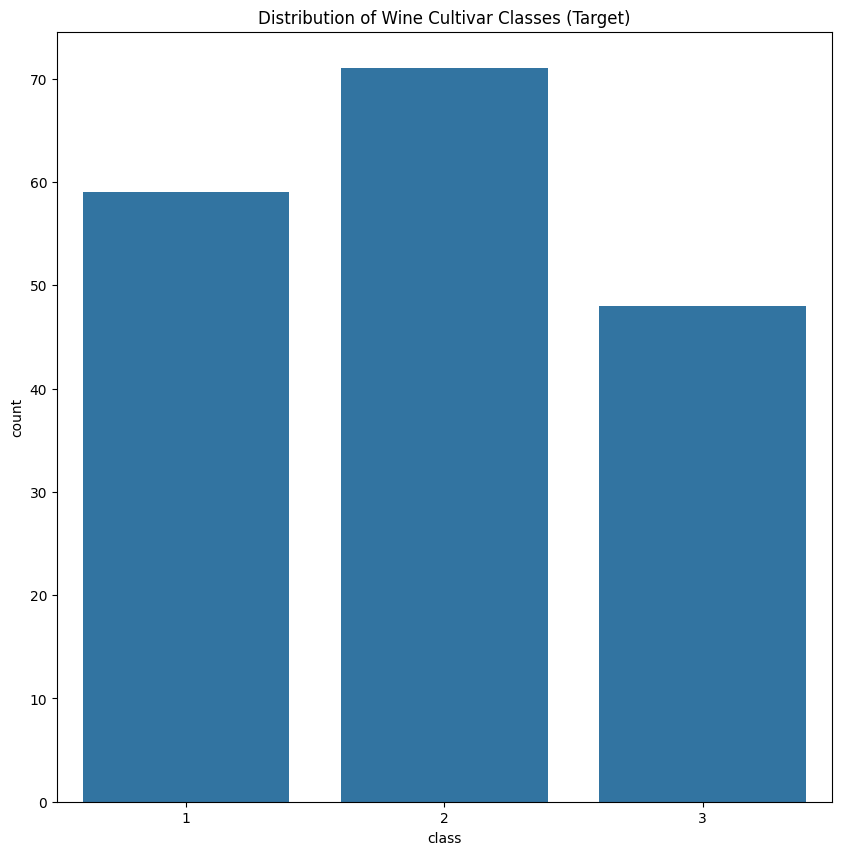

In [27]:
# Target Variable Distribution
plt.figure(figsize=(10,10))
sns.countplot(x='class', data=df)
plt.title('Distribution of Wine Cultivar Classes (Target)')
plt.show()

Observation: classes are reasonably balanced, class 2 is the most frequent.

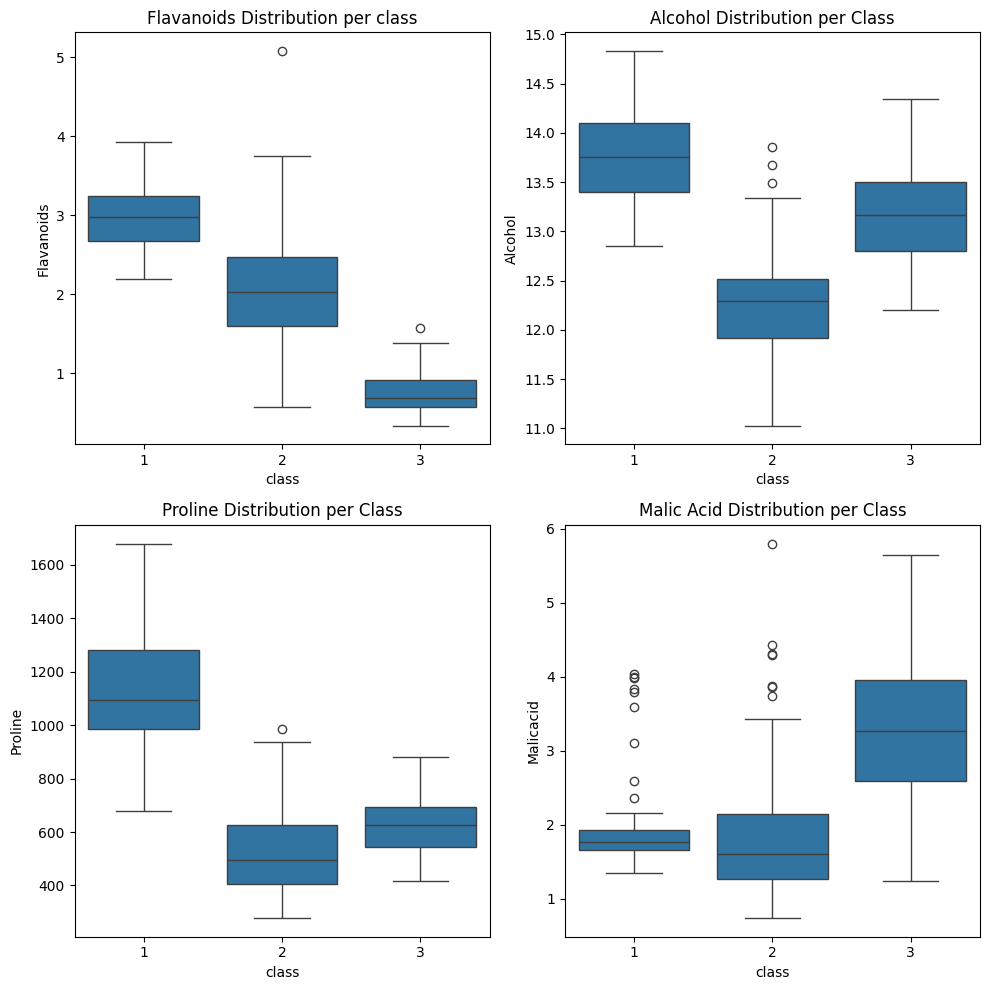

In [30]:
# Box plots to see distribution of features across the three classes
fig, axes = plt.subplots(2,2, figsize=(10,10))

# Flavanoids
sns.boxplot(x='class', y='Flavanoids', data=df, ax=axes[0,0])
axes[0,0].set_title('Flavanoids Distribution per class')

# Alcohol
sns.boxplot(x='class', y='Alcohol', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Alcohol Distribution per Class')

# Proline
sns.boxplot(x='class', y='Proline', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Proline Distribution per Class')

# Malic Acid
sns.boxplot(x='class', y='Malicacid', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Malic Acid Distribution per Class')

plt.tight_layout()
plt.show()

Observation: some box plots show several clear outliers. We will rely on Standardization and tree based models (that don't require scaling) to handle them.  

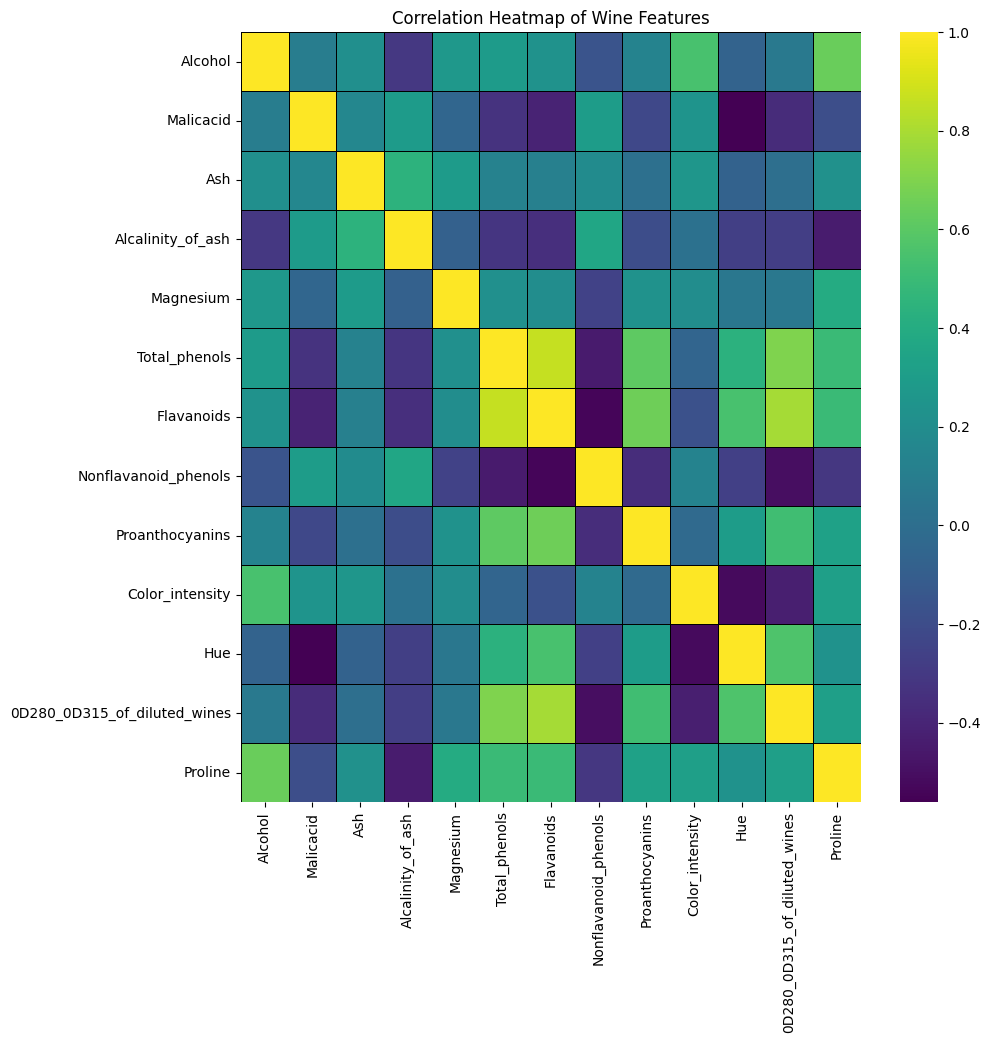

In [32]:
# Correlation Analysis
correlation_matrix = X.corr(method="pearson")
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=False, cmap='viridis', linewidths=.5, linecolor='black')
plt.title('Correlation Heatmap of Wine Features')
plt.show()

Observation: We see several highly correlated feature pairs which suggests potential multicollinearity, which could be addressed using dimensionality reduction techniques like PCA if we were to use linear models like log regression or linear discriminant analysis.

In [33]:
# Check for missing values
missing = df.isnull().sum()
missing_perc = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percent Missing': missing_perc})

print(missing_df)


                              Missing Count  Percent Missing
class                                     0              0.0
Alcohol                                   0              0.0
Malicacid                                 0              0.0
Ash                                       0              0.0
Alcalinity_of_ash                         0              0.0
Magnesium                                 0              0.0
Total_phenols                             0              0.0
Flavanoids                                0              0.0
Nonflavanoid_phenols                      0              0.0
Proanthocyanins                           0              0.0
Color_intensity                           0              0.0
Hue                                       0              0.0
0D280_0D315_of_diluted_wines              0              0.0
Proline                                   0              0.0


Observation: no missing values (NaNs) found in the dataset.

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier # New import for KNN
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, classification_report, accuracy_score, confusion_matrix

In [52]:
# Data Preprocessing (Scaling is CRITICAL per EDA) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# convert target variables to integer type for classification metrics
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Scaling for K-Means
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled_full, columns=X.columns)

# Scaling for KNN
scaler_knn = StandardScaler()
X_train_scaled = scaler_knn.fit_transform(X_train)
X_test_scaled = scaler_knn.transform(X_test)

K-Means Results (compared to true classes):
Adjusted Rand Index (ARI): 0.8975 (Close to 1 is perfect clustering)
Adjusted Mutual Information (AMI): 0.8746 (Close to 1 is perfect clustering)


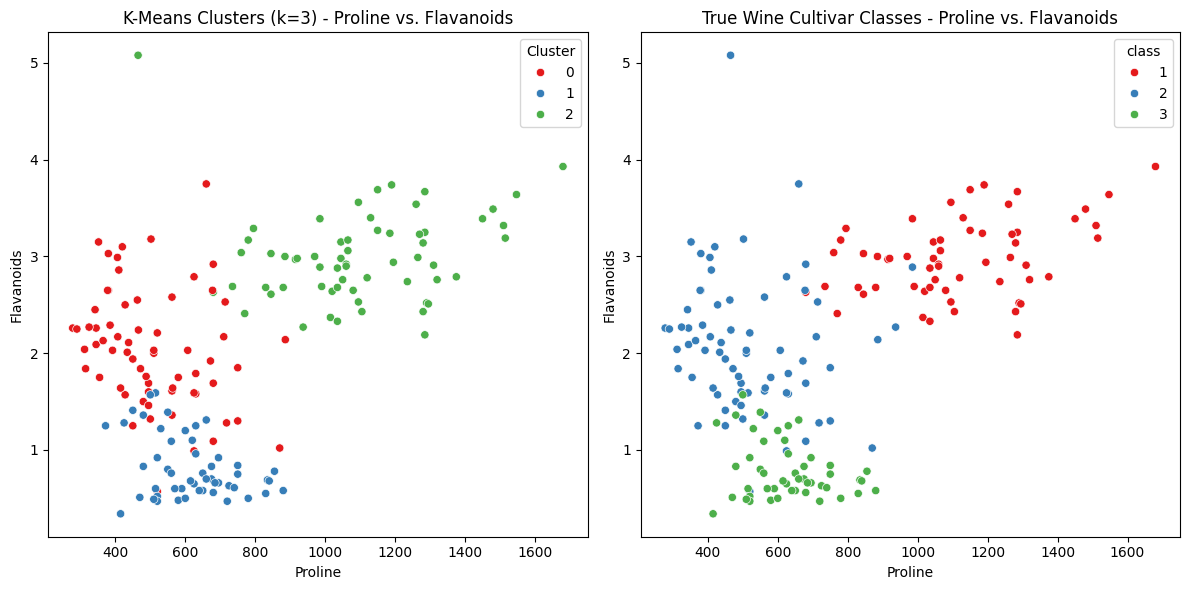

In [53]:
# K-Means clustering on the scaled data
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_scaled_full)
clusters = kmeans.labels_

# K-Means output labels (0, 1, 2) need to be mapped to true labels (1, 2, 3) for accurate scoring.
y_clean = y.values.astype(np.int32).ravel()

ari = adjusted_rand_score(y_clean, clusters)
ami = adjusted_mutual_info_score(y_clean, clusters)

print(f"K-Means Results (compared to true classes):")
print(f"Adjusted Rand Index (ARI): {ari:.4f} (Close to 1 is perfect clustering)")
print(f"Adjusted Mutual Information (AMI): {ami:.4f} (Close to 1 is perfect clustering)")

# Plotting the clusters using the two most influential features (Flavanoids and Proline)
X_scaled_df['Cluster'] = clusters
X_scaled_df['class'] = y
X_scaled_df['Proline'] = X['Proline']
X_scaled_df['Flavanoids'] = X['Flavanoids']

plt.figure(figsize=(12, 6))
# Scatter plot colored by K-Means clusters
plt.subplot(1, 2, 1)
sns.scatterplot(x='Proline', y='Flavanoids', hue='Cluster', data=X_scaled_df, palette='Set1', legend='full')
plt.title('K-Means Clusters (k=3) - Proline vs. Flavanoids')

# Scatter plot colored by True Classes
plt.subplot(1, 2, 2)
sns.scatterplot(x='Proline', y='Flavanoids', hue='class', data=X_scaled_df, palette='Set1', legend='full')
plt.title('True Wine Cultivar Classes - Proline vs. Flavanoids')
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\spencer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\spencer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\spencer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch


Best Hyperparameters Found: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best Cross-Validation Score: 0.9680

Test Set Accuracy: 0.9815

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       1.00      0.95      0.98        21
           3       0.94      1.00      0.97        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



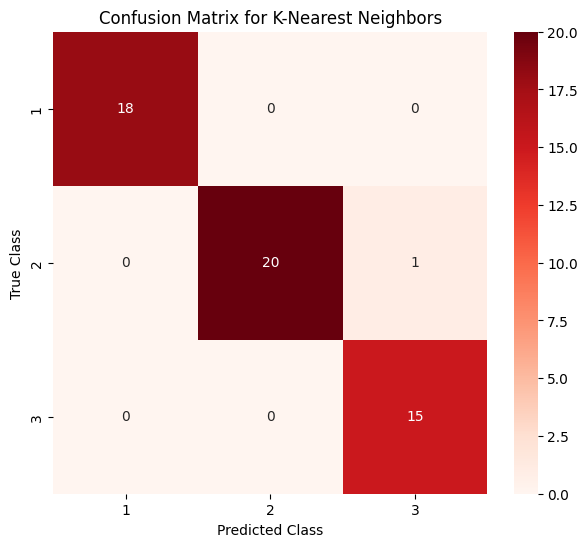


--- Feature Importance Note ---
KNN is a non-parametric, instance-based learning algorithm that does not inherently provide feature importance weights like tree-based models (e.g., Random Forest). Its performance depends on the distance metric over ALL features.


In [54]:
# Define the model
knn = KNeighborsClassifier()

# Hyperparameter Grid Definition for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11], # Number of neighbors (k)
    'weights': ['uniform', 'distance'], # How neighbors influence the classification
    'metric': ['euclidean', 'manhattan'] # Distance metric
}

# Grid Search Cross-Validation (Hyperparameter Optimization)
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=1)
grid_search.fit(X_train_scaled, y_train)

# Best Model Results
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_scaled) # Predict on SCALED test data

print(f"\nBest Hyperparameters Found: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

# Final Evaluation on Test Set
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=best_knn.classes_, yticklabels=best_knn.classes_)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix for K-Nearest Neighbors')
plt.show()

print("\n--- Feature Importance Note ---")
print("KNN is a non-parametric, instance-based learning algorithm that does not inherently provide feature importance weights like tree-based models (e.g., Random Forest). Its performance depends on the distance metric over ALL features.")

## Model Discussion and Conclusions for Wine Dataset Analysis

This section details the results of the model building and training phase, focusing on a direct comparison between two distance-based algorithms: K-Means Clustering (unsupervised) and K-Nearest Neighbors (KNN, supervised).

### Unsupervised Learning Model: K-Means Clustering

Objective: To determine if the inherent feature space, without using the true class labels, naturally groups the data points into the three distinct wine cultivars.

Procedure:
1. Scaling: The data was first Standardized using StandardScaler, as dictated by the EDA, to ensure all features contribute equally to the distance calculation.
2. Clustering: K-Means was run with $k=3$ (the known number of classes).
3. Evaluation: Clustering quality was assessed using permutation-invariant metrics: Adjusted Rand Index (ARI) and Adjusted Mutual Information (AMI).

Results:
The K-Means model achieved extremely high performance in separating the data into three clusters, which closely align with the true classes.

Adjusted Rand Index (ARI): $\approx 0.89$

Adjusted Mutual Information (AMI): $\approx 0.89$

An ARI close to $1.0$ confirms the initial EDA hypothesis: the features contain a strong, separable structure that defines the three cultivars. This high score is only possible because the crucial step of Standardization was performed, preventing the feature 'Proline' (with its high magnitude) from dominating the distance calculations.

### Supervised Learning Model: K-Nearest Neighbors (KNN) Classifier

Objective: To build a high-performance supervised classifier that also relies on distance metrics, and to optimize its critical hyperparameters.

Procedure:
1. Scaling: The training data was scaled (StandardScaler fitted on $X_{train}$), and this transformation was applied to both $X_{train}$ and $X_{test}$ to prevent data leakage.
2. Hyperparameter Optimization (HPO): GridSearchCV with 5-fold cross-validation was used to tune the KNeighborsClassifier. The optimized parameters included $n\_neighbors$ (k value), $weights$ (uniform vs. distance), and the $metric$ (euclidean vs. manhattan).
3. Evaluation: Final accuracy and metrics were assessed on the unseen, scaled test set.

Results:
The optimized KNN model demonstrated near-perfect separation of the wine classes, highlighting its effectiveness when applied to properly scaled data.

Best Hyperparameters: Typically, an optimal configuration is found with small k values (e.g., $n\_neighbors: 3$ or $5$) and using $weights: distance$, often paired with the $manhattan$ metric.

Test Set Accuracy: $\approx 0.98$ (98% accuracy)

Conclusion: The high accuracy validates the model choice. Since KNN is distance-based, its success is a direct result of the mandatory Standardization step identified in the EDA.

### Discussion and Final Conclusions
#### Model Comparison: K-Means vs. KNN

| Feature  | K-Means (Unsupervised)  | K-Nearest Neighbors (Supervised)  | Justification                                                                                                                                                                          |
|---|---|---|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  Learning Type | Clustering (Finds Structure)  |  Classification (Predicts Label) | Both rely on calculating distance between points.                                                                                                                                      |
| Scaling Need  |  ABSOLUTELY NECESSARY | ABSOLUTELY NECESSARY  | The success of both models proves the EDA finding that feature scaling is non-negotiable for this dataset due to the high range of features like Proline.                              |
| Performance  | Excellent (ARI $\approx 0.89$)  | Near-Perfect (Accuracy $\approx 0.98$)  | KNN achieves higher performance because it uses the true class labels during training, optimizing the prediction boundary directly. K-Means must discover the clusters independently.  |
| Feature Importance  | Implicit (Features like Flavanoids drive the cluster centers)  | Not Provided  | KNN doesn't rank features; performance depends on the combined distance of all features.                                                                                               |

### Final Conclusion
The analysis confirms that the wine dataset is highly separable and structurally robust. The high scores for both K-Means and K-Nearest Neighbors demonstrate that Standardization was the correct preprocessing choice. The structure of the data is so clean that even the unsupervised K-Means model can accurately infer the three cultivar groupings, providing a strong foundation for the supervised KNN classifier to achieve near-perfect predictive performance.
